# Making a convolutional autoencoder to denoise images

In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
from tqdm import tqdm
import random
from typing import List, Tuple, Literal
import torch.nn as nn
from torch.utils.data import Dataset

In [2]:
class NoisyMNISTDataset(Dataset):
    """
    Custom Dataset for MNIST with noisy data.

    Args:
        data (np.ndarray): Original MNIST data (images).
        labels (np.ndarray): MNIST labels corresponding to the data.
        noise_types (list): List of noise types to apply : ['gaussian', 's&p', 'poisson', 'speckle']
    """

    def __init__(
        self,
        data: np.ndarray,
        labels: np.ndarray,
        noise_types: Literal["gaussian", "s&p", "poisson", "speckle"],
    ) -> None:
        # convert to tensor and add channel dim
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
        self.labels = labels
        self.noisy_data = self._add_noise(data, noise_types)
        self.noisy_data = torch.tensor(self.noisy_data, dtype=torch.float32).unsqueeze(
            1
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.noisy_data[idx], self.data[idx]

    def _add_noise(self, data: np.ndarray, noise_types: list) -> np.ndarray:
        """
        Adds noise to the input data using different noise modes.
        """
        new_data = np.copy(data)
        for i, image in enumerate(new_data):
            print(f"Adding noise: {i + 1}/{len(new_data)}", end="\r")
            if "gaussian" in noise_types:
                image = random_noise(image, mode="gaussian", mean=0, var=0.1)
            if "s&p" in noise_types:
                image = random_noise(image, mode="s&p", amount=0.05, salt_vs_pepper=0.5)
            if "poisson" in noise_types:
                image = random_noise(image, mode="poisson")
            if "speckle" in noise_types:
                image = random_noise(image, mode="speckle", mean=0, var=0.05)
            new_data[i] = np.clip(image, 0, 1)
        print("Noise added.")
        return new_data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.numpy().squeeze())]
)
mnist_data = datasets.MNIST(
    root="../data", download=True, transform=transform, train=True
)
data, labels = mnist_data.data.numpy(), mnist_data.targets.numpy()
data = data / 255.0
noisy_dataset = NoisyMNISTDataset(
    data, labels, noise_types=["gaussian", "s&p", "poisson", "speckle"]
)
print(f"Dataset size: {len(noisy_dataset)}")

Noise added.: 60000/60000
Dataset size: 60000


Noisy Image Shape: torch.Size([1, 28, 28])
Clean Image Shape: torch.Size([1, 28, 28])


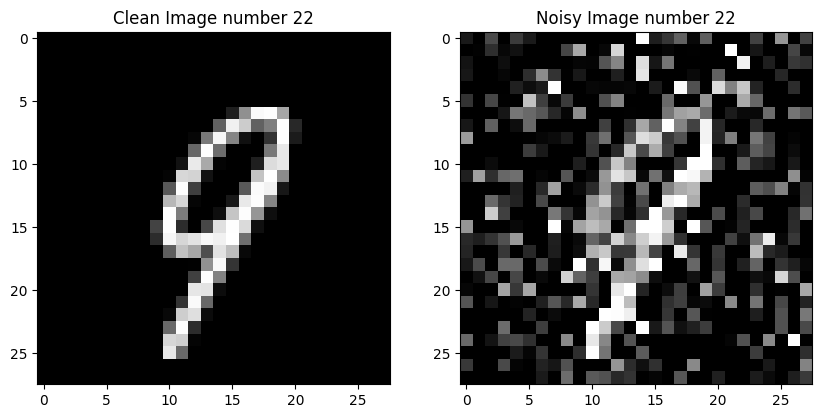

In [4]:
idx = 22
noisy_image, clean_image = noisy_dataset[idx]
print("Noisy Image Shape:", noisy_image.shape)
print("Clean Image Shape:", clean_image.shape)
noisy_image_np = noisy_image.squeeze().numpy()
clean_image_np = clean_image.squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].imshow(noisy_image_np, cmap="gray")
ax[1].set_title(f"Noisy Image number {idx}")
ax[0].imshow(clean_image_np, cmap="gray")
ax[0].set_title(f"Clean Image number {idx}")
plt.show()

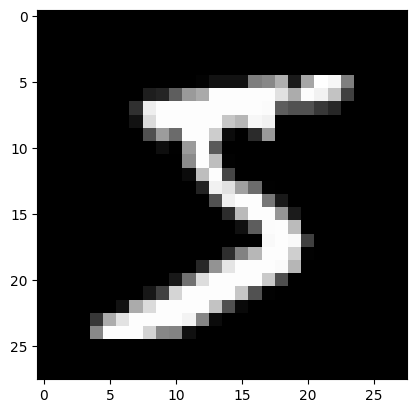

In [19]:
plt.imshow(noisy_dataset[0][1].squeeze().numpy(), cmap="gray")
# plt.imshow(noisy_dataset[0][0].squeeze().numpy(), cmap='gray')

In [6]:
random.seed(22)
torch.manual_seed(22)
train_size = int(0.8 * len(noisy_dataset))
test_size = len(noisy_dataset) - train_size
train_dataset, test_dataset = random_split(noisy_dataset, [train_size, test_size])
train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [22]:
train_size = len(train_dataset)
test_size = len(test_dataset)
print(f"Number of samples in the training set: {train_size}")
print(f"Number of samples in the test set: {test_size}")

Number of samples in the training set: 48000
Number of samples in the test set: 12000


In [23]:
print(
    f"We have {len(train_data_loader)} training batches, each has {train_data_loader.batch_size} samples"
)
print(
    f"We have {len(test_data_loader)} testing batches, each has {train_data_loader.batch_size} samples"
)

We have 750 training batches, each has 64 samples
We have 188 testing batches, each has 64 samples


- For the train dataloder, we have an exact division $(48000 / 64 = 750)$ with no remainder, so all the batches have the same number of samples
- For the test dataloder, when we divide the number of data points by the number of batch size we get $(12000 / 64 = 187,5)$ so the remaining 32 data points will be put in an extra batch to the total number of testing batches is the ceil which is 188 

In [ ]:
first_batch = next(iter(test_data_loader))
# the first element of the batch is 64 stacked tensors of shape (1,28,28) which are the noised images
# the second element of the batch is 64 stacked tensors of shape (1,28,28) which are the clean images
first_batch[1].shape

torch.Size([64, 1, 28, 28])

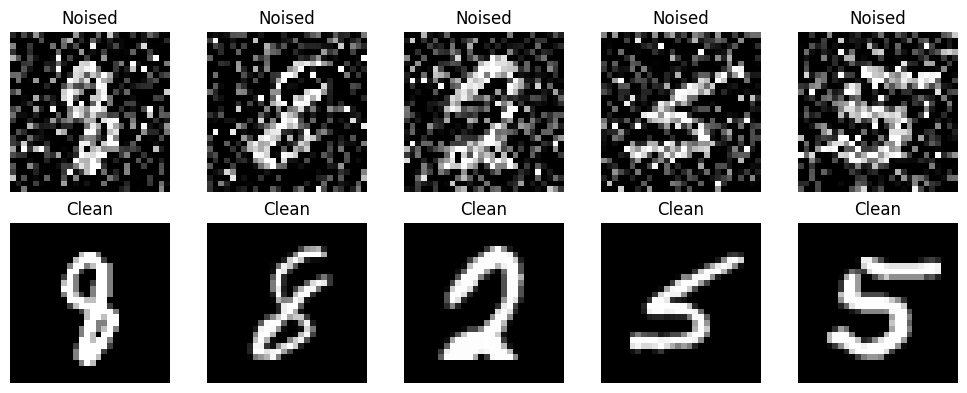

In [ ]:
noised_images = first_batch[0]  # of shape: (64, 1, 28, 28)
clean_images = first_batch[1]  # of shape: (64, 1, 28, 28)
num_samples = 5
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    # noisy images
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(noised_images[i].squeeze(), cmap="gray")
    plt.title("Noised")
    plt.axis("off")
    # clean images
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(clean_images[i].squeeze(), cmap="gray")
    plt.title("Clean")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class DenoiserAutoEncoder(nn.Module):
    """
    Denoiser AutoEncoder model for reconstructing clean images from noisy inputs.
    - The encoder compresses the input image to a latent space.
    - The decoder reconstructs the image from the encoded representation.
    """

    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def test_shapes(self, input_tensor: torch.Tensor) -> None:
        """Check if the reconstructed image has the same shape as the input image.
        Cause I struggled a little with shapes mismatch at fisrt :))
        """
        with torch.no_grad():
            self.eval()
            encoded = self.encoder(input_tensor)
            decoded = self.decoder(encoded)
            assert (
                decoded.shape == input_tensor.shape
            ), f"Shape mismatch :( -> original {input_tensor.shape}, reconstructed {decoded.shape}"
            print(f"All is well, shapes are matchy :) -> {decoded.shape}")

    def save_model(self, file_path: str = None) -> None:
        """
        Saves the model's state_dict to the specified file path.
        """
        torch.save(self.state_dict(), file_path)
        print(f"Model saved to --> {file_path}")

In [11]:
model = DenoiserAutoEncoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenoiserAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [12]:
input_tensor = torch.randn(1, 1, 28, 28).to(
    device
)  # (batch_size, channels, height, width)
model.test_shapes(input_tensor)

Shape match confirmed: torch.Size([1, 1, 28, 28])


In [13]:
num_epochs: int = 15
outputs: List[float] = []
epoch_train_losses: List[float] = []
epoch_test_losses: List[float] = []

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    # train dataloader has batches (lists) of two elements [noisy, clean] organized in stacked 64 tensors each
    progress_bar = tqdm(
        train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True
    )
    for noisy_img, clean_img in progress_bar:
        noisy_img = noisy_img.to(device)
        # Forward pass
        reconstructed_img = model(noisy_img)
        # we compute the loss between the reconstructed image and the original clean iamge
        loss = criterion(reconstructed_img, clean_img)
        # bakcpop and optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.5f}")

    # avg training losses
    avg_train_loss = epoch_train_loss / len(train_data_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f"Epoch: {epoch+1} | Avg Train Loss: {avg_train_loss:.5f}")
    outputs.append((epoch, noisy_img, reconstructed_img))
    # testing (no gradients needed)
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for noisy_image, clean_image in test_data_loader:
            # forward pass the noisy image
            reconstrcuted_image = noisy_image.to(device)
            reconstructed_img = model(noisy_image)
            loss = criterion(reconstructed_img, clean_image)
            epoch_test_loss += loss.item()

    # avg test losses
    avg_test_loss = epoch_test_loss / len(test_data_loader)
    epoch_test_losses.append(avg_test_loss)
    print(f"Epoch: {epoch+1} | Avg Test Loss: {avg_test_loss:.5f}")

Epoch 1/15:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 750/750 [00:06<00:00, 109.46it/s, loss=0.01983]


Epoch: 1 | Avg Train Loss: 0.05072
Epoch: 1 | Avg Test Loss: 0.01956


Epoch 2/15: 100%|██████████| 750/750 [00:07<00:00, 106.24it/s, loss=0.01333]


Epoch: 2 | Avg Train Loss: 0.01527
Epoch: 2 | Avg Test Loss: 0.01280


Epoch 3/15: 100%|██████████| 750/750 [00:09<00:00, 81.58it/s, loss=0.01042]


Epoch: 3 | Avg Train Loss: 0.01187
Epoch: 3 | Avg Test Loss: 0.01104


Epoch 4/15: 100%|██████████| 750/750 [00:09<00:00, 75.62it/s, loss=0.01074]


Epoch: 4 | Avg Train Loss: 0.01063
Epoch: 4 | Avg Test Loss: 0.01024


Epoch 5/15: 100%|██████████| 750/750 [00:07<00:00, 103.50it/s, loss=0.00973]


Epoch: 5 | Avg Train Loss: 0.00994
Epoch: 5 | Avg Test Loss: 0.00980


Epoch 6/15: 100%|██████████| 750/750 [00:07<00:00, 96.54it/s, loss=0.00957] 


Epoch: 6 | Avg Train Loss: 0.00952
Epoch: 6 | Avg Test Loss: 0.00942


Epoch 7/15: 100%|██████████| 750/750 [00:08<00:00, 86.46it/s, loss=0.00822]


Epoch: 7 | Avg Train Loss: 0.00922
Epoch: 7 | Avg Test Loss: 0.00928


Epoch 8/15: 100%|██████████| 750/750 [00:09<00:00, 77.56it/s, loss=0.00858]


Epoch: 8 | Avg Train Loss: 0.00902
Epoch: 8 | Avg Test Loss: 0.00916


Epoch 9/15: 100%|██████████| 750/750 [00:09<00:00, 75.05it/s, loss=0.00865]


Epoch: 9 | Avg Train Loss: 0.00886
Epoch: 9 | Avg Test Loss: 0.00898


Epoch 10/15: 100%|██████████| 750/750 [00:10<00:00, 73.30it/s, loss=0.00870]


Epoch: 10 | Avg Train Loss: 0.00877
Epoch: 10 | Avg Test Loss: 0.00895


Epoch 11/15: 100%|██████████| 750/750 [00:10<00:00, 70.80it/s, loss=0.00820]


Epoch: 11 | Avg Train Loss: 0.00867
Epoch: 11 | Avg Test Loss: 0.00894


Epoch 12/15: 100%|██████████| 750/750 [00:10<00:00, 70.09it/s, loss=0.00878]


Epoch: 12 | Avg Train Loss: 0.00862
Epoch: 12 | Avg Test Loss: 0.00875


Epoch 13/15: 100%|██████████| 750/750 [00:10<00:00, 68.68it/s, loss=0.00745]


Epoch: 13 | Avg Train Loss: 0.00855
Epoch: 13 | Avg Test Loss: 0.00869


Epoch 14/15: 100%|██████████| 750/750 [00:10<00:00, 68.28it/s, loss=0.00813]


Epoch: 14 | Avg Train Loss: 0.00850
Epoch: 14 | Avg Test Loss: 0.00869


Epoch 15/15: 100%|██████████| 750/750 [00:10<00:00, 71.79it/s, loss=0.00819]


Epoch: 15 | Avg Train Loss: 0.00845
Epoch: 15 | Avg Test Loss: 0.00859


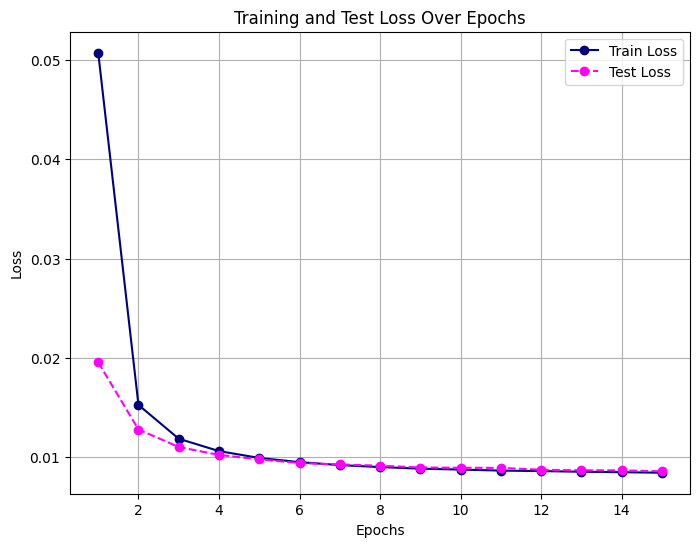

In [14]:
def plot_loss(train_losses: List[float], test_losses: List[float]) -> None:
    plt.figure(figsize=(8, 6))
    plt.plot(
        range(1, len(train_losses) + 1),
        train_losses,
        marker="o",
        linestyle="-",
        color="navy",
        label="Train Loss",
    )
    plt.plot(
        range(1, len(test_losses) + 1),
        test_losses,
        marker="o",
        linestyle="--",
        color="magenta",
        label="Test Loss",
    )
    plt.title("Training and Test Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


plot_loss(epoch_train_losses, epoch_test_losses)

In [15]:
model.save_model("cached_model/denoiser_autoencoder_.pth")

Model saved to --> cached_model/denoiser_autoencoder_.pth


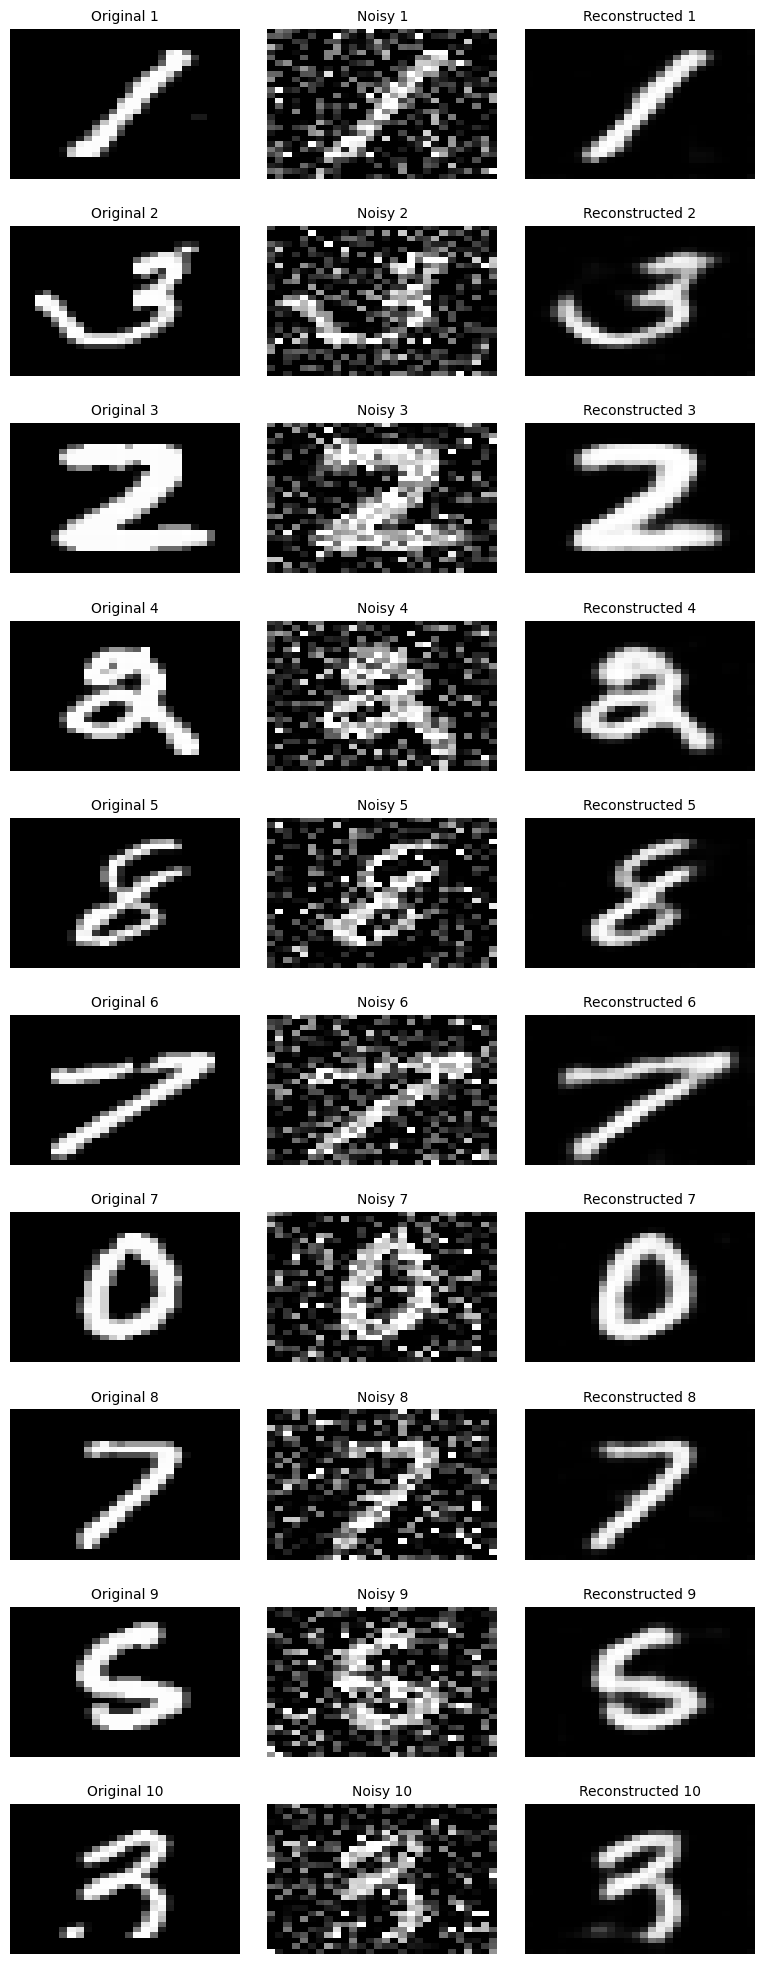

In [16]:
def inference(
    model: DenoiserAutoEncoder,
    data_loader: DataLoader,
    num_samples: int = 10,
    seed: int = 42,
):
    """
    Select `num_samples` random images from the dataset, pass them through the model,
    and visualize the original image, the noisy input image, and the reconstructed image.
    """
    random.seed(seed)
    model.eval()
    with torch.no_grad():
        for noisy_img, original_img in data_loader:
            indices = random.sample(range(noisy_img.size(0)), num_samples)
            noisy_images = noisy_img[indices].to(device)
            original_images = original_img[indices].cpu().numpy()
            # forward pass the img
            reconstructed_img = model(noisy_images)
            reconstructed_images = reconstructed_img.cpu().detach().numpy()
            fig, axes = plt.subplots(num_samples, 3, figsize=(8, 2 * num_samples))
            for i in range(num_samples):
                # og img
                axes[i, 0].imshow(
                    original_images[i].squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 0].set_title(f"Original {i+1}", fontsize=10)
                axes[i, 0].axis("off")
                # noisy img
                axes[i, 1].imshow(
                    noisy_images[i].cpu().numpy().squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 1].set_title(f"Noisy {i+1}", fontsize=10)
                axes[i, 1].axis("off")
                # reconstructed img
                axes[i, 2].imshow(
                    reconstructed_images[i].squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 2].set_title(f"Reconstructed {i+1}", fontsize=10)
                axes[i, 2].axis("off")
            plt.subplots_adjust(hspace=0.5, wspace=0.5)
            plt.tight_layout(pad=2.0)
            plt.show()
            break  # just the first batch


inference(model, test_data_loader, num_samples=10, seed=23)